<a href="https://colab.research.google.com/github/philipp-ding/google_colab_aml/blob/main/AML_exercise1_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daten importieren

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, \
HistGradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import cross_validate, cross_val_predict


In [17]:
house_price_df = pd.read_csv("/ames.csv")

## Data preprocessing and exploration

In [18]:
one_hot_encoded_df = pd.get_dummies(house_price_df)
correlations_sale_price = one_hot_encoded_df.corr()[['Sale_Price']].sort_values(by="Sale_Price").drop("Sale_Price")
pd.set_option("display.max_rows", 400)
threshold = 0.4
correlations_sale_price[(correlations_sale_price["Sale_Price"]>threshold) | (correlations_sale_price["Sale_Price"]<-threshold)] 

,Sale_Price
Exter_Qual_Typical,-0.590897
Kitchen_Qual_Typical,-0.526721
Fireplace_Qu_No_Fireplace,-0.481446
Bsmt_Qual_Typical,-0.452487
Garage_Finish_Unf,-0.421876
Overall_Qual_Very_Good,0.415559
Garage_Finish_Fin,0.424902
Neighborhood_Northridge_Heights,0.433299
Exter_Qual_Good,0.446489
Heating_QC_Excellent,0.454553


## sklearn preprocessing version

In [19]:
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)

# define preprocessor for trees
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)

In [20]:
# define preprocessor for linear models
cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)

In [21]:
# make pipelines
lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
rf_pipeline = make_pipeline(tree_preprocessor, \
                            RandomForestRegressor(random_state=42))
gbdt_pipeline = make_pipeline(
    tree_preprocessor, HistGradientBoostingRegressor(random_state=0)
)

# create stacked model
estimators = [
    ("Random Forest", rf_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", gbdt_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

## Train models and evaluate Results

In [25]:
# train test split
y = house_price_df["Sale_Price"]
house_price_df_X = house_price_df.drop("Sale_Price", axis=1)
y_test = y.iloc[:2001]
y_train = y.iloc[2001:]
X_test = house_price_df_X.iloc[:2001]
X_train = house_price_df_X.iloc[2001:]

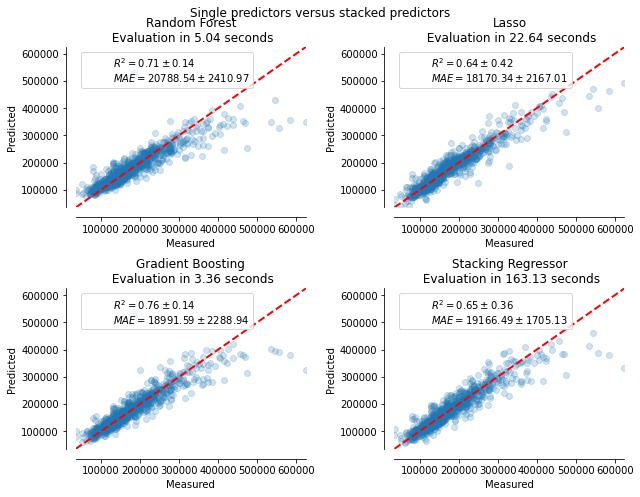

In [28]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    start_time = time.time()
    score = cross_validate(
        est, X_train, y_train, scoring=["r2", "neg_mean_absolute_error"], 
        n_jobs=2, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X_train, y_train, n_jobs=2, verbose=0)

    plot_regression_results(
        ax,
        y_train,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()